In [14]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from scipy import linalg
from skimage.transform import resize
from mintpy.utils import ptime, readfile, writefile, plot as pp, utils as ut
from mintpy.asc_desc2horz_vert import get_design_matrix4east_north_up
from mintpy.ifgram_inversion import skip_invalid_obs
from mintpy.cli import view, image_stitch, save_gdal
from mintpy.view import prep_slice, plot_slice
plt.rcParams.update({'font.size': 12})

# platform - laptop
proj_dir = os.path.expanduser('~/data/archives/2024NotoEQ/data')
work_dir = os.path.join(proj_dir, 'defo3d')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# output grid
S, N, W, E = 36.7, 37.6, 136.6, 137.45
ref_lat, ref_lon = 36.83, 137.01

# output
dis_enu_file     = os.path.join(work_dir, 'dis_enu.h5')
dis_enu_std_file = os.path.join(work_dir, 'dis_enu_std.h5')

Go to directory: /Users/yunjunz/data/archives/2024NotoEQ/data/defo3d


### 1. Read displacement and geometry

In [15]:
# inputs
# ALL files MUST be geocoded into the same bounding box (SNWE)
dis_files = [
    os.path.join(proj_dir, 'ALOS2_A121_20220926_20240101_OFF_RG/offRg.geo'),
    os.path.join(proj_dir, 'ALOS2_D026_20230606_20240102_OFF_RG/offRg.geo'),
    os.path.join(proj_dir, 'ALOS2_A127_20231206_20240103_OFF_RG/offRg.geo'),
    os.path.join(proj_dir, 'ALOS2_A128_20230612_20240108_OFF_RG/offRg.geo'),
    os.path.join(proj_dir, 'ALOS2_D019_20211019_20240109_OFF_RG/offRg.geo'),
    os.path.join(proj_dir, 'ALOS2_A121_20220926_20240101_OFF_AZ/offAz.geo'),
    os.path.join(proj_dir, 'ALOS2_A127_20231206_20240103_OFF_AZ/offAz.geo'),
    os.path.join(proj_dir, 'ALOS2_D019_20211019_20240109_OFF_AZ/offAz.geo'),
]
dis_std_files = [
    os.path.join(proj_dir, 'ALOS2_A121_20220926_20240101_OFF_RG/offRgStd.geo'),
    os.path.join(proj_dir, 'ALOS2_D026_20230606_20240102_OFF_RG/offRgStd.geo'),
    os.path.join(proj_dir, 'ALOS2_A127_20231206_20240103_OFF_RG/offRgStd.geo'),
    os.path.join(proj_dir, 'ALOS2_A128_20230612_20240108_OFF_RG/offRgStd.geo'),
    os.path.join(proj_dir, 'ALOS2_D019_20211019_20240109_OFF_RG/offRgStd.geo'),
    os.path.join(proj_dir, 'ALOS2_A121_20220926_20240101_OFF_AZ/offAzStd.geo'),
    os.path.join(proj_dir, 'ALOS2_A127_20231206_20240103_OFF_AZ/offAzStd.geo'),
    os.path.join(proj_dir, 'ALOS2_D019_20211019_20240109_OFF_AZ/offAzStd.geo'),
]
enu_files = [os.path.join(os.path.dirname(x), 'enu.geo') for x in dis_files]
num_file = len(dis_files)

In [16]:
atr = readfile.read_attribute(dis_files[0])
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
dis     = np.full((num_file, length, width), np.nan, dtype=np.float32)
dis_std = np.full((num_file, length, width), np.nan, dtype=np.float32)
ve      = np.full((num_file, length, width), np.nan, dtype=np.float32)
vn      = np.full((num_file, length, width), np.nan, dtype=np.float32)
vu      = np.full((num_file, length, width), np.nan, dtype=np.float32)

for i, (dis_file, dis_std_file, enu_file) in enumerate(zip(dis_files, dis_std_files, enu_files)):
    # read displacement and its std
    print(f'read data from file {i+1}: {dis_file}')
    dis_i, atr_i = readfile.read(dis_file)
    dis_std_i = readfile.read(dis_std_file)[0]

    # read unit vector
    ve_i = readfile.read(enu_file, datasetName='band1')[0]
    vn_i = readfile.read(enu_file, datasetName='band2')[0]
    vu_i = readfile.read(enu_file, datasetName='band3')[0]

    # spatial referencing
    coord = ut.coordinate(atr_i)
    ref_y, ref_x = coord.geo2radar(ref_lat, ref_lon)[:2]
    print(f'\tspatial referencing to (lat, lon) = ({ref_lat}, {ref_lon}), (y, x) = ({ref_y}, {ref_x})')
    if np.isnan(dis_i[ref_y, ref_x]):
        raise ValueError('reference point is in masked out region! Choose a different one!')
    dis_i -= dis_i[ref_y, ref_x]

    # resize
    if dis_i.shape != (length, width):
        print(f'\tresizing shape from {dis_i.shape} to {(length,width)}')
        kwargs = dict(output_shape=(length, width), order=0, mode='constant', anti_aliasing=False, preserve_range=True)
        #kwargs = dict(output_shape=(length, width), order=1, mode='constant', anti_aliasing=True, preserve_range=True)
        dis_i     = resize(np.array(dis_i),     **kwargs)
        dis_std_i = resize(np.array(dis_std_i), **kwargs)
        ve_i      = resize(np.array(ve_i),      **kwargs)
        vn_i      = resize(np.array(vn_i),      **kwargs)
        vu_i      = resize(np.array(vu_i),      **kwargs)

    dis[i] = dis_i
    dis_std[i] = dis_std_i
    ve[i] = ve_i
    vn[i] = vn_i
    vu[i] = vu_i
print('finished reading data.')

read data from file 1: /Users/yunjunz/data/archives/2024NotoEQ/data/ALOS2_A121_20220926_20240101_OFF_RG/offRg.geo
	spatial referencing to (lat, lon) = (36.83, 137.01), (y, x) = (1386, 588)
read data from file 2: /Users/yunjunz/data/archives/2024NotoEQ/data/ALOS2_D026_20230606_20240102_OFF_RG/offRg.geo
	spatial referencing to (lat, lon) = (36.83, 137.01), (y, x) = (1386, 588)
read data from file 3: /Users/yunjunz/data/archives/2024NotoEQ/data/ALOS2_A127_20231206_20240103_OFF_RG/offRg.geo
	spatial referencing to (lat, lon) = (36.83, 137.01), (y, x) = (1386, 588)
read data from file 4: /Users/yunjunz/data/archives/2024NotoEQ/data/ALOS2_A128_20230612_20240108_OFF_RG/offRg.geo
	spatial referencing to (lat, lon) = (36.83, 137.01), (y, x) = (1386, 588)
read data from file 5: /Users/yunjunz/data/archives/2024NotoEQ/data/ALOS2_D019_20211019_20240109_OFF_RG/offRg.geo
	spatial referencing to (lat, lon) = (36.83, 137.01), (y, x) = (1386, 588)
read data from file 6: /Users/yunjunz/data/archives/202

In [18]:
dis.shape

(8, 1620, 1219)

save figure to file /Users/yunjunz/data/archives/2024NotoEQ/data/defo3d/pic/dis_los.png


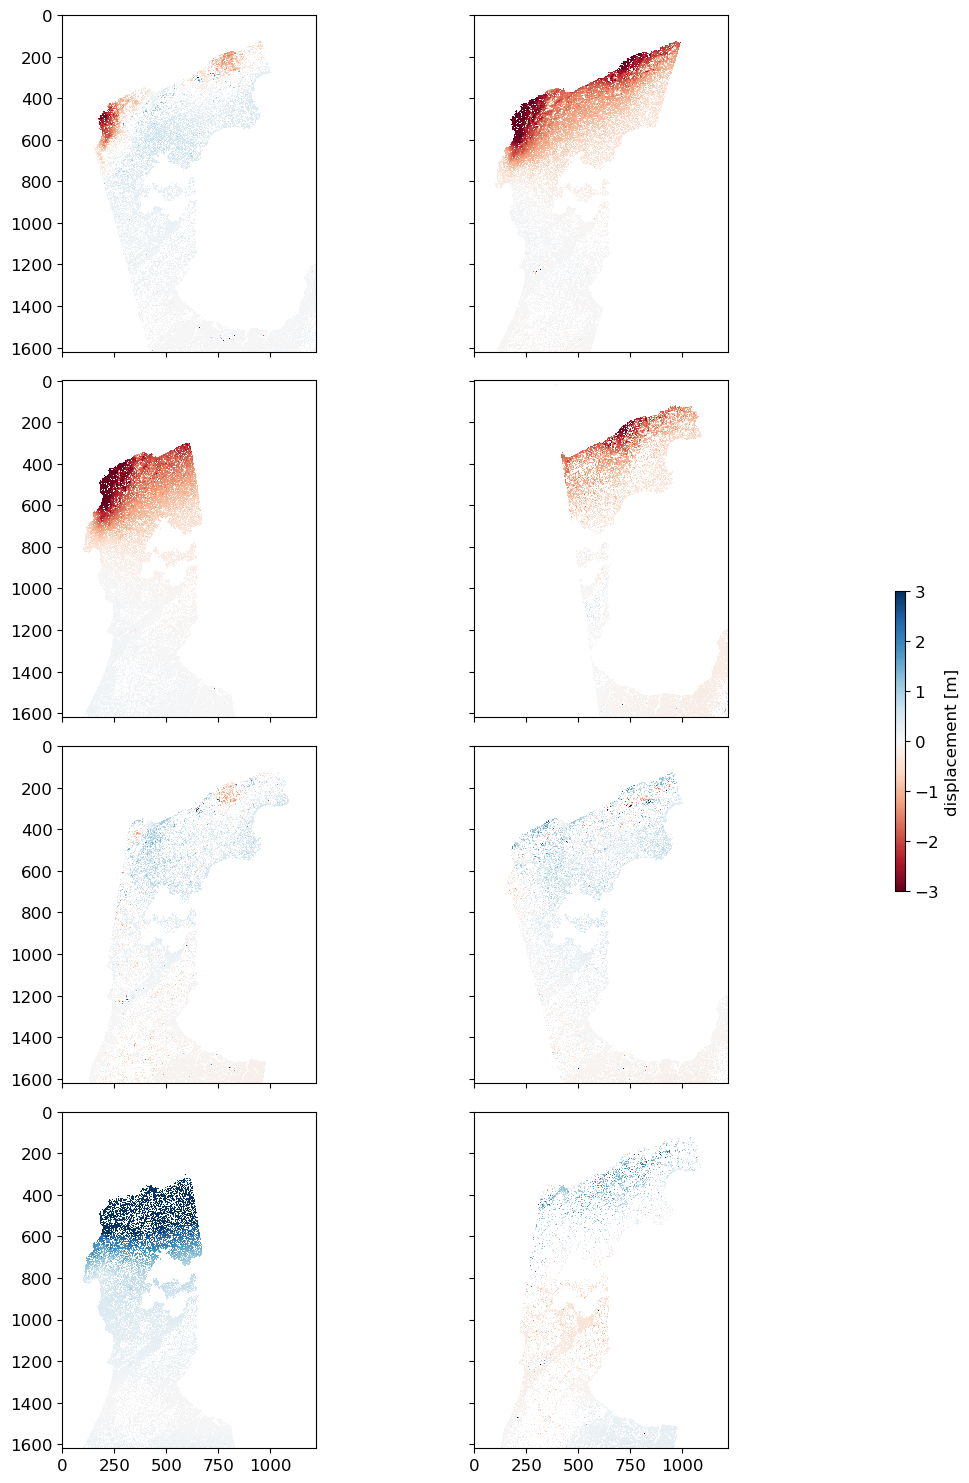

In [20]:
# plot
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=[10, 15], sharex=True, sharey=True)
axs = axs.flatten()[:num_file]
for i, ax in enumerate(axs):
    im = ax.imshow(dis[i], vmin=-3, vmax=3, cmap='RdBu', interpolation='nearest')
    #im = ax.imshow(dis_std_mat[i,:], vmin=0, vmax=1.0, cmap='RdBu_r', interpolation='nearest')
fig.tight_layout()

# axis format
cax = fig.add_axes([1.0, 0.4, 0.01, 0.2])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('displacement [m]')

out_fig = os.path.join(work_dir, f'pic/dis_los.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 2. Estimate 3D displacement field

In [21]:
def estimate_enu_displacement(dis_los, dis_los_std, G, weight=False):

    dis_los = dis_los.reshape(G.shape[0], -1)
    dis_los_std = dis_los_std.reshape(G.shape[0], -1)

    # initial output value
    dis_enu     = np.full(3, np.nan, dtype=np.float32)
    dis_enu_std = np.full(3, np.nan, dtype=np.float32)

    # skip pixels with none in all files
    if np.all(np.isnan(dis_los)):
        return dis_enu, dis_enu_std

    # skip invalid observations in some files
    dis_los, [G, dis_los_std] = skip_invalid_obs(dis_los, mat_list=[G, dis_los_std])

    # invert
    if weight:
        w_sqrt = 1. / dis_los_std
        X, e2 = linalg.lstsq(np.multiply(G, w_sqrt), np.multiply(dis_los, w_sqrt), cond=1e-5)[:2]
    else:
        X, e2 = linalg.lstsq(G, dis_los, cond=1e-5)[:2]

    if e2.size != 0:
        dis_enu = X.flatten()

        # calculate inversion quality
        Gplus = linalg.pinv(G)
        dis_los_cov = np.diag(np.square(dis_los_std.flatten()))
        dis_enu_cov = np.linalg.multi_dot([Gplus, dis_los_cov, Gplus.T])
        dis_enu_std = np.sqrt(np.diag(dis_enu_cov))

    return dis_enu, dis_enu_std

In [22]:
# calculate the weight matrix
weight = True

# pixel-wise inversion with invalid pixels skipped.
dis_enu = np.zeros((3, length, width), dtype=np.float32) * np.nan
dis_enu_std = np.zeros((3, length, width), dtype=np.float32) * np.nan
num_pix = length * width
prog_bar = ptime.progressBar(maxValue=num_pix)
for i in range(num_pix):
    prog_bar.update(i+1, every=1000, suffix=f'{i+1} / {num_pix}')
    y, x = i // width, i % width

    # prepare inputs
    dis_los = dis[:, y, x]
    dis_los_std = dis_std[:, y, x]
    G = np.zeros((num_file, 3), dtype=np.float32)
    G[:, 0] = ve[:, y, x]
    G[:, 1] = vn[:, y, x]
    G[:, 2] = vu[:, y, x]

    dis_enu_i, dis_enu_std_i = estimate_enu_displacement(dis_los, dis_los_std, G, weight=weight)
    dis_enu[:, y, x] = dis_enu_i.flatten()
    dis_enu_std[:, y, x] = dis_enu_std_i.flatten()
prog_bar.close()

[==================================================] 1974780 / 1974780   77s /     1s 


### 3. Plot

save figure to file /Users/yunjunz/data/archives/2024NotoEQ/data/defo3d/pic/dis_enu.png


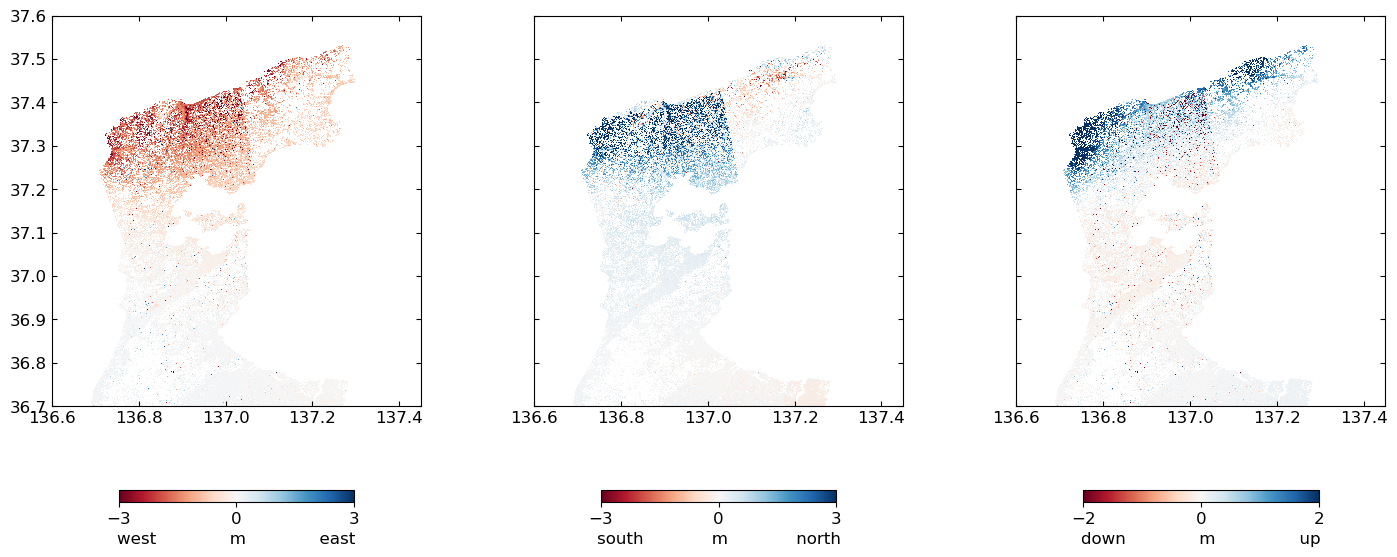

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharex=True, sharey=True)
kwargs = dict(extent=(W, E, S, N), cmap='RdBu', interpolation='nearest')
vlims = [3, 3, 2]
im1 = axs[0].imshow(dis_enu[0,:].reshape(length, width), vmin=-vlims[0], vmax=vlims[0], **kwargs)
im2 = axs[1].imshow(dis_enu[1,:].reshape(length, width), vmin=-vlims[1], vmax=vlims[1], **kwargs)
im3 = axs[2].imshow(dis_enu[2,:].reshape(length, width), vmin=-vlims[2], vmax=vlims[2], **kwargs)
ims = [im1, im2, im3]
labels = ['west              m              east',
          'south             m             north',
          'down              m                up']
for i, (ax, im, label, vlim) in enumerate(zip(axs, ims, labels, vlims)):
    cbar = fig.colorbar(im, ax=ax, shrink=0.5, orientation='horizontal', ticks=[-vlim, 0, vlim])
    cbar.set_label(label)
fig.tight_layout()
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)

# output
out_fig = os.path.join(work_dir, f'pic/dis_enu.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()